This notebook will go through the process for clustering songs into playlists using the Mean Shift algorithm

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift

In [2]:
raw_data = pd.read_csv('dataset.csv')
print(raw_data.head())

   danceability  energy  key  loudness  speechiness  acousticness  \
0         0.680   0.729    7    -5.097       0.0418        0.3670   
1         0.584   0.607   11    -6.605       0.0356        0.4260   
2         0.703   0.643    7    -5.544       0.0706        0.1920   
3         0.746   0.450    7    -8.543       0.0872        0.0407   
4         0.561   0.597   11    -6.000       0.0405        0.2860   

   instrumentalness  liveness  valence    tempo  time_signature  \
0               0.0    0.1590    0.830  120.029               4   
1               0.0    0.1010    0.374  117.817               4   
2               0.0    0.1430    0.528  102.059               4   
3               0.0    0.1720    0.336   95.998               4   
4               0.0    0.0979    0.355   76.826               4   

                 song_uri                     name  mode_major  mode_minor  
0  3TMUdD9vE4DoqDYi7VXStt              Fool's Gold           1           0  
1  3TKpJrY9q49Mj1JOsM9zGL   

In [3]:
scaler = StandardScaler()

cols_to_scale = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 
'acousticness','instrumentalness','liveness','valence','tempo','time_signature']

raw_data = raw_data.astype({'key': 'float64', 'time_signature':'float64'}, copy=True)
scaled_data = raw_data.copy()
scaled_data = scaled_data.drop(columns=['song_uri', 'name'])
# scaled_data = scaled_data.drop(columns=['song_uri', 'name', 'loudness', 'liveness', 'time_signature'])
# scaled_data = scaled_data.drop(columns=['song_uri', 'name', 'loudness', 'liveness', 'time_signature', 'instrumentalness', 'speechiness'])

print(scaled_data.head())
algo_data = scaled_data.to_numpy()

   danceability  energy   key  loudness  speechiness  acousticness  \
0         0.680   0.729   7.0    -5.097       0.0418        0.3670   
1         0.584   0.607  11.0    -6.605       0.0356        0.4260   
2         0.703   0.643   7.0    -5.544       0.0706        0.1920   
3         0.746   0.450   7.0    -8.543       0.0872        0.0407   
4         0.561   0.597  11.0    -6.000       0.0405        0.2860   

   instrumentalness  liveness  valence    tempo  time_signature  mode_major  \
0               0.0    0.1590    0.830  120.029             4.0           1   
1               0.0    0.1010    0.374  117.817             4.0           1   
2               0.0    0.1430    0.528  102.059             4.0           1   
3               0.0    0.1720    0.336   95.998             4.0           1   
4               0.0    0.0979    0.355   76.826             4.0           0   

   mode_minor  
0           0  
1           0  
2           0  
3           0  
4           1  


In [4]:
print(scaled_data.shape)

(2156, 13)


So the hyperparameter for Mean Shift with a flat kernel is the bandwidth.<br>
To find some realistic values for that, let's do some quick analysis.

In [5]:
min_feature_values = np.min(scaled_data)
max_feature_values = np.max(scaled_data)
distance = max_feature_values - min_feature_values
print('\nMax possible distance: {}'.format(np.linalg.norm(distance.values)))


Max possible distance: 162.51068223535762


So, an absolute maximum distance in our transformed feature space is about 162.<br>
As bandwidth rises, there will be fewer clusters

We will test values of 2-7 in increments of 0.5

In [6]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

results = pd.DataFrame(columns=['bandwidth', 'sil_score', 'db_score'])

from progressbar import ProgressBar
pbar = ProgressBar()
for bw in pbar(np.arange(2,7,0.5)):
    algo = MeanShift(bandwidth=bw).fit(algo_data)
    labels = algo.labels_
    num_labels = len(set(labels))
    num_samples = len(algo_data)
    if num_labels <= 2 or num_labels == num_samples:
        sil_score = -1
        db_score = 10
    else:
        sil_score = silhouette_score(algo_data, labels)
        db_score = davies_bouldin_score(algo_data, labels)
    results = results.append({
        'bandwidth': bw,
        'num_clusters': num_labels,
        'sil_score': sil_score,
        'db_score': db_score
    }, ignore_index=True)
        
print(results)

C:\Users\srija\Miniconda3\envs\spotify\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\srija\Miniconda3\envs\spotify\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\srija\Miniconda3\envs\spotify\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\srija\Miniconda3\envs\spotify\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
C:\Users\srija\Miniconda3\envs\spotify\lib\site-packages\sklearn\metrics\cluster\unsuper

   bandwidth  sil_score  db_score  num_clusters
0        2.0   0.190138  0.680188         596.0
1        2.5   0.200570  0.807906         322.0
2        3.0   0.214254  0.856191         188.0
3        3.5   0.206710  0.912818         113.0
4        4.0   0.231916  0.884801          73.0
5        4.5   0.251040  0.909596          52.0
6        5.0   0.242736  0.989076          35.0
7        5.5   0.249058  0.982559          28.0
8        6.0   0.293394  0.867640          18.0
9        6.5   0.295584  1.003715          16.0


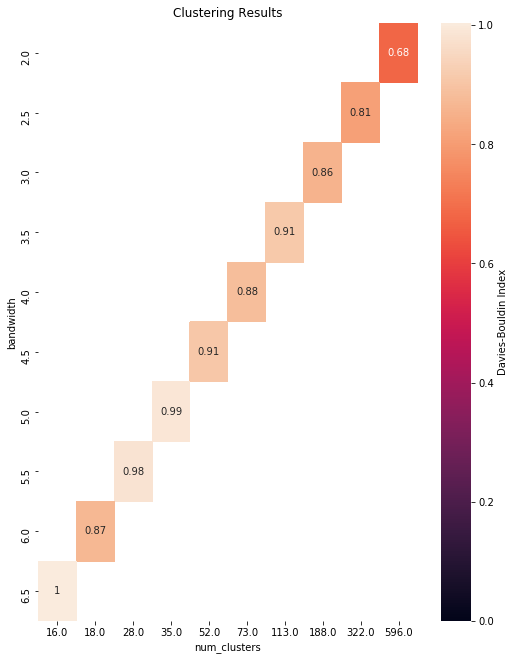

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

heatmap_results = results.pivot(index='bandwidth', columns='num_clusters', values='db_score')
plt.figure(figsize=(8.5,11))
ax = plt.axes()
# sns.heatmap(heatmap_results, cbar_kws={'label': 'Silhouette Score'}, ax=ax, vmin=-1.0, vmax=1.0, annot=True)
sns.heatmap(heatmap_results, cbar_kws={'label': 'Davies-Bouldin Index'}, ax=ax, vmin=0, annot=True)
ax.set_title('Clustering Results')
plt.show()

In [30]:
algo = MeanShift(bandwidth=2).fit(algo_data)
labels = algo.labels_
clusters = set(labels)

total_songs = len(labels)
n_clusters_ = len(set(labels))
print('Number of clusters: {}'.format(n_clusters_))

playlist_clusters = []
for cluster_num, ndx in enumerate(clusters):
    num_points = sum(labels == ndx)
    if (num_points > 10):
        print('\nCluster {}'.format(cluster_num + 1))
        print('Number of Points: {}'.format(num_points))
        cluster = raw_data.iloc[(labels == ndx), :]
        print('Cluster Songs:\n{}'.format(cluster.name))
        playlist_clusters.append(ndx)

Number of clusters: 596

Cluster 1
Number of Points: 33
Cluster Songs:
90                                           I Found You
118     Under The Sun (with J. Cole & Lute feat. DaBaby)
131                                 To My Future Wife...
162                                    Meet Me in London
376                                             Problems
440                                       Get Back Right
547              CLOSE (feat. Travis Scott) - From SR3MM
603                                              44 More
726                                                  Boy
741                              Met Gala (feat. Offset)
742                         Glorious (feat. Skylar Grey)
747                                Double (feat. Offset)
814                                        Hit This Hard
908                                                Liger
996                                                 DNA.
1029                                      New Illuminati
1064             

In [31]:
output_data = raw_data.copy()
output_data = output_data[['song_uri', 'name']]
output_data['cluster'] = labels
output_data = output_data[output_data.cluster.isin(playlist_clusters)]
print(output_data.shape)

(558, 3)


In [32]:
print(output_data.head())

                  song_uri                name  cluster
0   3TMUdD9vE4DoqDYi7VXStt         Fool's Gold        7
3   3GRSqlALWISqLeNncZMbpX             Mean It        1
6   649o53ULWYN1y7V2OI5kgo  Heat of the Summer       26
8   2a3dopgTF1q4rMVDJ1rwBU        Push My Luck        3
23  5n0CTysih20NYdT2S0Wpe8             Trouble      105


In [33]:
output_data.to_csv('bw_2.csv')